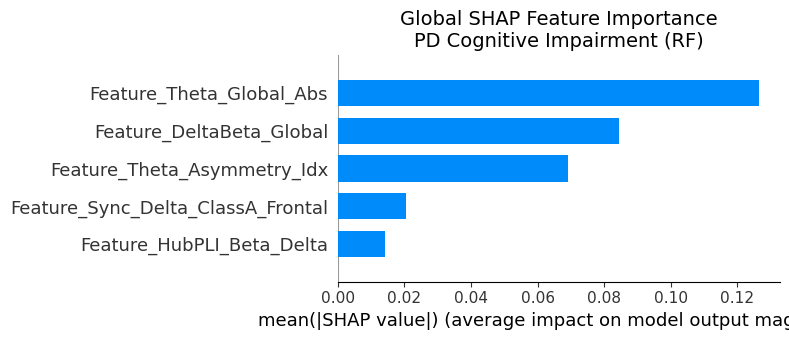

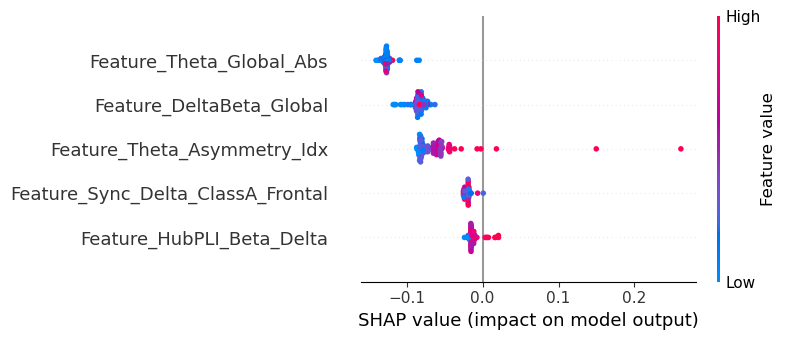

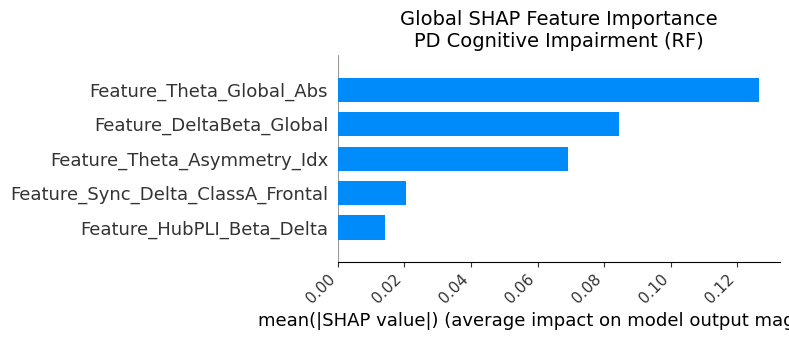

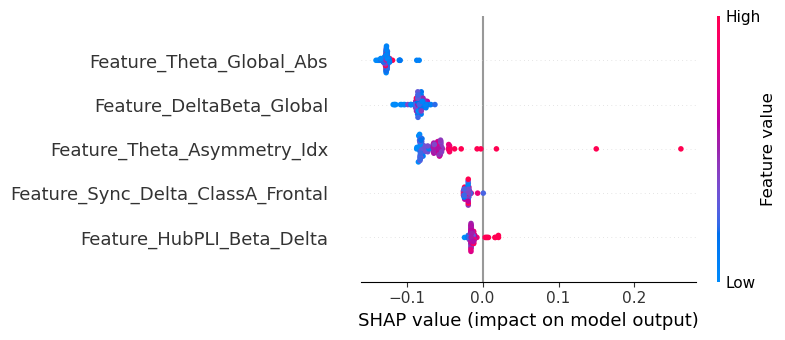

In [3]:
import shap
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# =========================
# LOAD MODEL + DATA
# =========================
model = joblib.load(
    r"C:\Users\User\Documents\EEG_Project\PD_MoCA_RF_5Feature_Final.pkl"
)

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

df = pd.read_csv(
    r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv"
)

X = df[FEATURES]

# Extract trained RF from pipeline
rf = model.named_steps['rf']

# =========================
# SHAP EXPLAINER
# =========================
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_vals = shap_values[0]          # class 1 = cognitively impaired
else:
    shap_vals = shap_values[:, :, 0]    # class 1

assert shap_vals.shape == X.shape, (
    f"SHAP shape {shap_vals.shape} does not match X shape {X.shape}"
)

# =========================
# GLOBAL EXPLANATION (BAR)
# =========================
plt.figure(figsize=(10,6))  # <- make figure bigger
shap.summary_plot(
    abs(shap_vals),
    X,
    feature_names=FEATURES,
    plot_type="bar",
    show=False
)
plt.title("Global SHAP Feature Importance\nPD Cognitive Impairment (RF)", fontsize=14)
plt.tight_layout()
plt.show()

# =========================
# FEATURE DISTRIBUTION (BEESWARM)
# =========================
plt.figure(figsize=(12,8))  # <- make beeswarm bigger
shap.summary_plot(
    shap_vals,   # for beeswarm you can use raw SHAP values
    X,
    feature_names=FEATURES,
    show=True
)
# =========================
# GLOBAL EXPLANATION (BAR)
# =========================
plt.figure(figsize=(12,6))  # wider to fit x-axis text
shap.summary_plot(
    abs(shap_vals),
    X,
    feature_names=FEATURES,
    plot_type="bar",
    show=False
)
plt.title("Global SHAP Feature Importance\nPD Cognitive Impairment (RF)", fontsize=14)
plt.xticks(rotation=45, ha='right')  # rotate x labels
plt.tight_layout()
plt.show()

# =========================
# FEATURE DISTRIBUTION (BEESWARM)
# =========================
plt.figure(figsize=(14,8))  # wider for long feature names
shap.summary_plot(
    shap_vals,
    X,
    feature_names=FEATURES,
    show=True
)



In [4]:
# =========================
# NUMERIC GLOBAL IMPORTANCE
# =========================

mean_abs_shap = np.mean(np.abs(shap_vals), axis=0)

shap_importance = (
    pd.DataFrame({
        "Feature": FEATURES,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
    .reset_index(drop=True)
)

print("\nMean Absolute SHAP Importance (Global Effect Size):")
print(shap_importance)

shap_importance.to_csv(
    r"C:\Users\User\Documents\EEG_Project\PD_MoCA_SHAP_MeanImportance.csv",
    index=False
)



Mean Absolute SHAP Importance (Global Effect Size):
                             Feature  MeanAbsSHAP
0           Feature_Theta_Global_Abs     0.126454
1           Feature_DeltaBeta_Global     0.084457
2        Feature_Theta_Asymmetry_Idx     0.069060
3  Feature_Sync_Delta_ClassA_Frontal     0.020444
4          Feature_HubPLI_Beta_Delta     0.014096


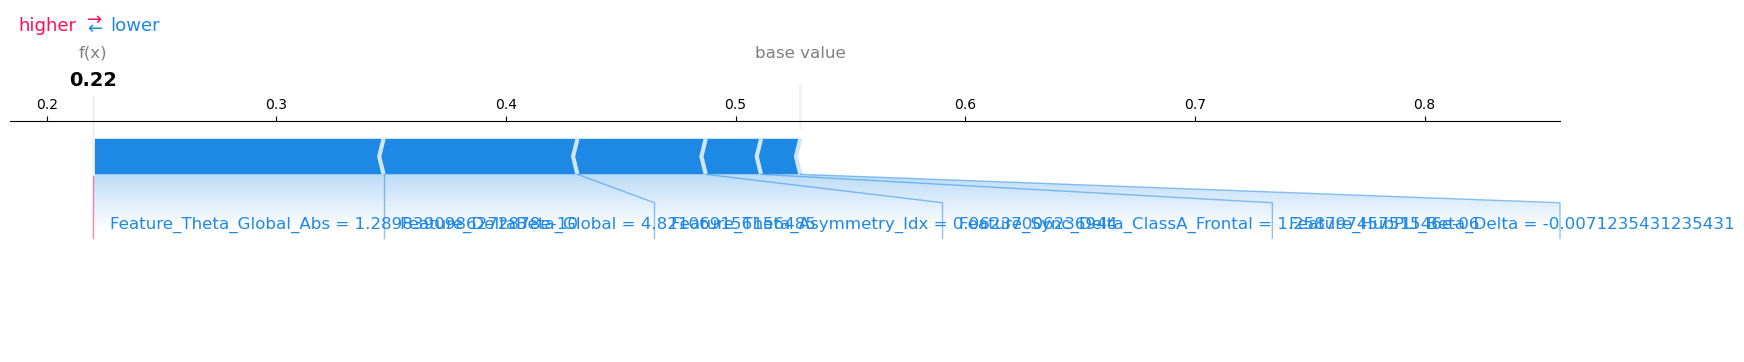

In [5]:
# Pick a subject index
idx = 2

shap.force_plot(
    explainer.expected_value[1],
    shap_vals[idx],
    X.iloc[idx],
    matplotlib=True
)


In [6]:
import shap
import matplotlib.pyplot as plt

# =========================
# PICK SUBJECT
# =========================
idx = 1

# =========================
# GET PREDICTION
# =========================
pred_prob = model.predict_proba(X[idx].reshape(1, -1))[0, 1]
pred_label = "Impaired" if pred_prob >= 0.5 else "Unimpaired"

true_label = y[idx]
true_label_name = "Impaired" if true_label == 1 else "Unimpaired"


plt.figure(figsize=(10, 5))

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    shap_vals[idx],
    feature_names=FEATURES,
    max_display=5
)

plt.title(
    f"Subject {idx} | Actual: {true_label_name} | "
    f"Predicted: {pred_label} (P={pred_prob:.2f})"
)

plt.tight_layout()
plt.show()

print("Predicted probability:", pred_prob)
print("True label:", true_label)


KeyError: 1

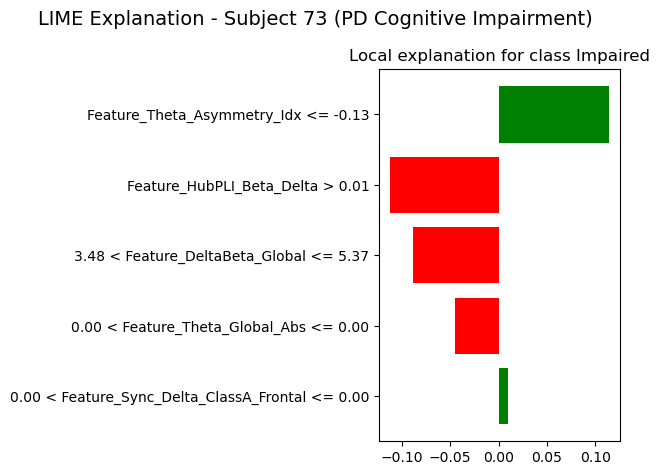

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# =========================
# LOAD DATA + MODEL
# =========================
model = joblib.load(r"C:\Users\User\Documents\EEG_Project\PD_MoCA_RF_5Feature_Final.pkl")

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\ML_Feature_Matrix.csv")
X = df[FEATURES].values
y = df['Label_Impaired'].values

# Extract Random Forest from pipeline
rf = model.named_steps['rf']

# =========================
# CREATE LIME EXPLAINER
# =========================
explainer_lime = LimeTabularExplainer(
    training_data=X,
    feature_names=FEATURES,
    class_names=['Unimpaired', 'Impaired'],
    mode='classification',
    discretize_continuous=True
)

# =========================
# EXPLAIN A SINGLE SUBJECT
# =========================
idx =  73#96 # choose subject82
exp = explainer_lime.explain_instance(
    data_row=X[idx],
    predict_fn=model.predict_proba,
    num_features=5
)

# =========================
# PLOT USING MATPLOTLIB
# =========================
fig = exp.as_pyplot_figure()
fig.suptitle(f"LIME Explanation - Subject {idx} (PD Cognitive Impairment)", fontsize=14)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score
import shap

# =========================
# 1. LOAD DATA
# =========================
df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv")

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

X = df[FEATURES]
y = df['Label_Impaired'].values

# =========================
# 2. SPLIT TRAIN / TEST
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=4224
)

# =========================
# 3. DEFINE PIPELINE
# =========================
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42, max_depth=10))
])

# =========================
# 4. CROSS-VALIDATION ON TRAINING SET
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring_metrics, return_train_score=False)

print("\n--- CV Performance on TRAINING SET ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# 5. TRAIN FINAL MODEL ON TRAINING SET
# =========================
pipeline.fit(X_train, y_train)

# =========================
# 6. FEATURE IMPORTANCE
# =========================
rf_model = pipeline.named_steps['rf']
importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\n--- Feature Importances ---")
print(importances)

# =========================
# 7. PREDICTIONS ON TEST SET
# =========================
all_probs = pipeline.predict_proba(X_test)[:, 1]
all_preds = (all_probs >= 0.5).astype(int)
errors = np.where(all_preds != y_test)[0]
print(f"\nErrors on test set: {len(errors)} out of {len(y_test)}")

# =========================
# 8. SHAP EXPLAINER ON TEST SET
# =========================
explainer = shap.TreeExplainer(rf_model)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)
shap_values = explainer.shap_values(X_test_scaled)

print("\nSHAP values computed on test set.")



--- CV Performance on TRAINING SET ---
AUC: 0.772 ± 0.049
Accuracy: 0.725 ± 0.064
F1: 0.720 ± 0.092
Precision: 0.781 ± 0.137
Recall: 0.708 ± 0.174
BalancedAcc: 0.722 ± 0.064

--- Feature Importances ---
Feature_Theta_Global_Abs             0.264062
Feature_Sync_Delta_ClassA_Frontal    0.222756
Feature_HubPLI_Beta_Delta            0.182328
Feature_DeltaBeta_Global             0.177987
Feature_Theta_Asymmetry_Idx          0.152866
dtype: float64

Errors on test set: 6 out of 20

SHAP values computed on test set.


In [50]:
import matplotlib.pyplot as plt
# =========================
# 9. PICK SUBJECT (Individual Prediction & SHAP)
# =========================

# Choose an index from your test set (0 to len(X_test)-1)
idx = 30


# 1. Get the scaled data for this specific subject
X_test_row = X_test.iloc[[idx]]
X_test_row_scaled = pipeline.named_steps['scaler'].transform(X_test_row)

# 2. Get Prediction and Probability
# We use the pipeline directly so it handles the scaling for us
pred_prob = pipeline.predict_proba(X_test_row)[0, 1]
pred_label = "Impaired" if pred_prob >= 0.5 else "Unimpaired"

true_label = y_test[idx]
true_label_name = "Impaired" if true_label == 1 else "Unimpaired"

# 3. Handle SHAP values
# If shap_values is a list (common in older versions), we take [1] for Impaired
if isinstance(shap_values, list):
    subject_shap = shap_values[1][idx]
    base_value = explainer.expected_value[1]
else:
    # Newer versions return a 3D array [samples, features, classes]
    subject_shap = shap_values[idx, :, 1]
    base_value = explainer.expected_value[1]

# 4. Visualization
plt.figure(figsize=(10, 5))

# Using the legacy waterfall to match your requested format
shap.plots._waterfall.waterfall_legacy(
    base_value,
    subject_shap,
    feature_names=FEATURES,
    max_display=5,
    show=False # Allows us to add a title before showing
)

plt.title(
    f"Subject (Test Index {idx}) | Actual: {true_label_name} | "
    f"Predicted: {pred_label} (P={pred_prob:.2f})",
    pad=20
)

plt.tight_layout()
plt.show()

print(f"--- Analysis for Test Subject at Index {idx} ---")
print(f"Predicted probability of Impairment: {pred_prob:.4f}")
print(f"True Label: {true_label} ({true_label_name})")

IndexError: positional indexers are out-of-bounds

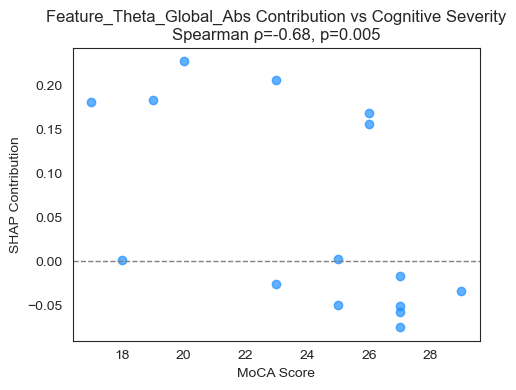

In [55]:
# =========================
# SHAP vs MoCA (All Test Subjects)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# -------------------------
# 1. Compute SHAP on X_test_scaled
# -------------------------
rf_model = pipeline.named_steps['rf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)  # scaled test set

# -------------------------
# 2. Extract impaired-class SHAP
# -------------------------
if isinstance(shap_values, list):
    # Old SHAP versions: list per class
    shap_impaired = shap_values[1]
elif shap_values.ndim == 3:
    # New SHAP versions: [samples, features, classes]
    shap_impaired = shap_values[:, :, 1]
else:
    # Already single-class SHAP
    shap_impaired = shap_values

# -------------------------
# 3. Pick feature to plot
# -------------------------
feature_name = 'Feature_Theta_Global_Abs'
f_idx = FEATURES.index(feature_name)

# -------------------------
# 4. Align MoCA values from full df
# -------------------------
df_full = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv")
df_plot = pd.DataFrame({
    'MoCA': df_full.loc[X_test.index, 'Target_MoCA'].values,
    'SHAP': shap_impaired[:, f_idx]
})

# -------------------------
# 5. Compute Spearman correlation
# -------------------------
rho, pval = spearmanr(df_plot['MoCA'], df_plot['SHAP'])

# -------------------------
# 6. Plot
# -------------------------
plt.figure(figsize=(5, 4))
plt.scatter(df_plot['MoCA'], df_plot['SHAP'], alpha=0.7, color='dodgerblue')
plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.xlabel('MoCA Score')
plt.ylabel('SHAP Contribution')
plt.title(f'{feature_name} Contribution vs Cognitive Severity\nSpearman ρ={rho:.2f}, p={pval:.3f}')
plt.tight_layout()
plt.show()


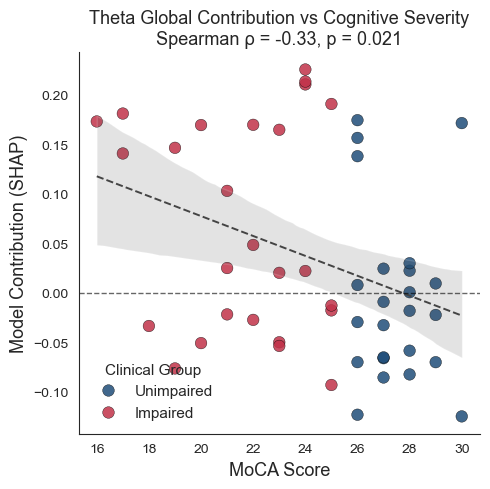

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

# -------------------------
# 1. Compute SHAP on X_test_scaled
# -------------------------
rf_model = pipeline.named_steps['rf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# -------------------------
# 2. Extract impaired-class SHAP
# -------------------------
if isinstance(shap_values, list):
    shap_impaired = shap_values[1]
elif shap_values.ndim == 3:
    shap_impaired = shap_values[:, :, 1]
else:
    shap_impaired = shap_values

# -------------------------
# 3. Feature selection
# -------------------------
feature_name = 'Feature_Theta_Global_Abs'
f_idx = FEATURES.index(feature_name)

# -------------------------
# 4. Build plotting dataframe
# -------------------------
df_full = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv")

df_plot = pd.DataFrame({
    'MoCA': df_full.loc[X_test.index, 'Target_MoCA'].values,
    'SHAP': shap_impaired[:, f_idx],
    'Label': ['Impaired' if l == 1 else 'Unimpaired' for l in y_test]
})

# -------------------------
# 5. Statistics
# -------------------------
rho, pval = spearmanr(df_plot['MoCA'], df_plot['SHAP'])

# -------------------------
# 6. Clean, poster-ready plot
# -------------------------
sns.set_style("white")
plt.figure(figsize=(5,5))

palette = {
    'Impaired': "#C13249",     # dark purple
    'Unimpaired': '#1F4E79'    # dark blue (PowerPoint default-ish)
}

sns.scatterplot(
    data=df_plot,
    x='MoCA',
    y='SHAP',
    hue='Label',
    palette=palette,
    s=70,
    alpha=0.85,
    edgecolor='black',
    linewidth=0.3
)

# Regression line (subtle, neutral)
sns.regplot(
    data=df_plot,
    x='MoCA',
    y='SHAP',
    scatter=False,
    color='#444444',
    line_kws={'linestyle': '--', 'linewidth': 1.4}
)

plt.axhline(0, linestyle='--', linewidth=1, color='black', alpha=0.6)

plt.xlabel('MoCA Score', fontsize=13)
plt.ylabel('Model Contribution (SHAP)', fontsize=13)

plt.title(
    f'Theta Global Contribution vs Cognitive Severity\n'
    f'Spearman ρ = {rho:.2f}, p = {pval:.3f}',
    fontsize=13
)

plt.legend(
    title='Clinical Group',
    frameon=False,
    fontsize=11,
    title_fontsize=11
)
plt.legend(
    title='Clinical Group',
    frameon=False,
    fontsize=11,
    title_fontsize=11
)

# Force integer x-axis ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

sns.despine()
plt.tight_layout()
plt.show()


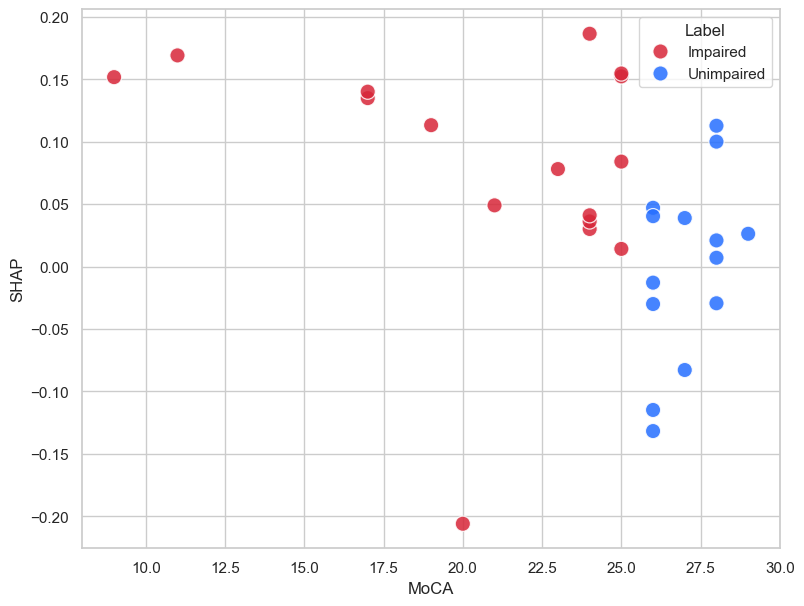

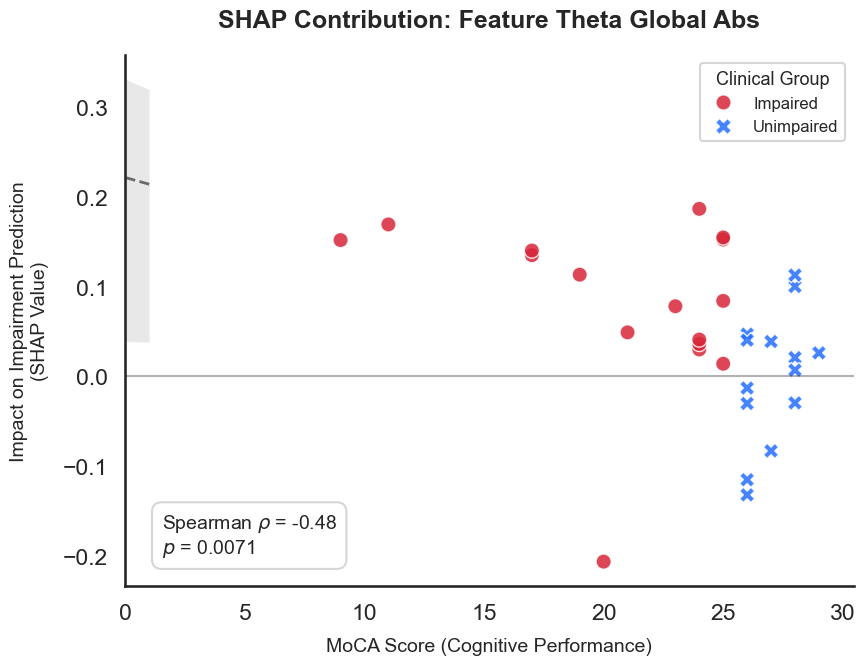

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Set Global Aesthetics ---
sns.set_context("talk") # Makes labels/lines larger for presentations
sns.set_style("white")  # Clean background

# 1. Create Figure
fig, ax = plt.subplots(figsize=(9, 7))

# 2. Add a confidence interval band with the regression line
# We use a muted color for the line so it doesn't distract from the raw data
sns.regplot(
    data=df_plot, x='MoCA', y='SHAP',
    scatter=False, color='dimgray', 
    line_kws={'linestyle': '--', 'linewidth': 2},
    truncate=False, ax=ax
)

# 3. Enhanced Scatter Plot
# Increased 's' (size) and added 'edgecolor' for pop
scatter = sns.scatterplot(
    data=df_plot, x='MoCA', y='SHAP',
    hue='Label', style='Label', # Different shapes help with colorblindness
    palette={'Impaired': '#D72638', 'Unimpaired': '#256EFF'}, # Punchier colors
    s=120, alpha=0.85, edgecolor='w', linewidth=1,
    ax=ax
)

# 4. Refined Baseline
ax.axhline(0, color='black', alpha=0.3, lw=1.5, zorder=1)

# 5. Dynamic Title & Stats Box
# Moving stats to a text box can often look cleaner than a long title
stats_text = f"Spearman $ρ$ = {rho:.2f}\n$p$ = {pval:.4f}"
ax.text(0.05, 0.05, stats_text, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='0.8'))

# 6. Labeling
feature_clean = feature_name.replace('_', ' ')
ax.set_title(f'SHAP Contribution: {feature_clean}', pad=20, fontweight='bold', fontsize=18)
ax.set_xlabel('MoCA Score (Cognitive Performance)', fontsize=14, labelpad=10)
ax.set_ylabel('Impact on Impairment Prediction\n(SHAP Value)', fontsize=14, labelpad=10)

# 7. Cleanup Spines
sns.despine() # Removes top and right borders

# 8. Legend Customization
ax.legend(title='Clinical Group', title_fontsize='13', fontsize='12', frameon=True)

plt.tight_layout()
plt.show()